In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from bloch.bloch import bloch
import os.path

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
# Excitation pulse calculation
pulse_dur_exc = 5
pulse_raw = np.loadtxt('p90_norm.txt')

EXC_AMP_INT = pulse_raw.sum()

amp_int_rel = EXC_AMP_INT / pulse_raw.size
fa = 90
pulse_length_exc = pulse_dur_exc / 1E3  # In s.
pulse_amp_hz = 500 * (1E-3/pulse_length_exc) * (fa/180) * (1/amp_int_rel)
exc_pulse_hz = pulse_raw
exc_pulse_hz *= pulse_amp_hz
print(pulse_amp_hz)

338.6231390411876


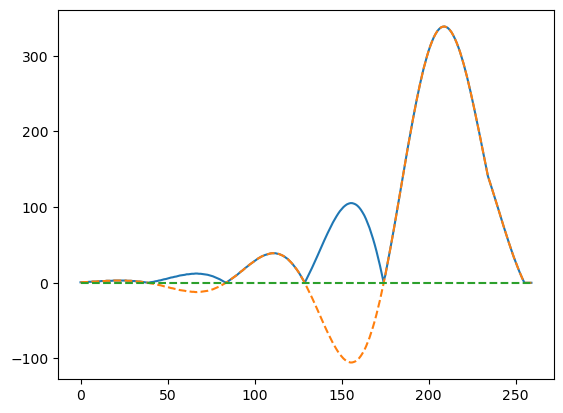

In [3]:
plt.plot(np.abs(exc_pulse_hz))
plt.plot(exc_pulse_hz.real,'--')
plt.plot(exc_pulse_hz.imag,'--')
plt.show()

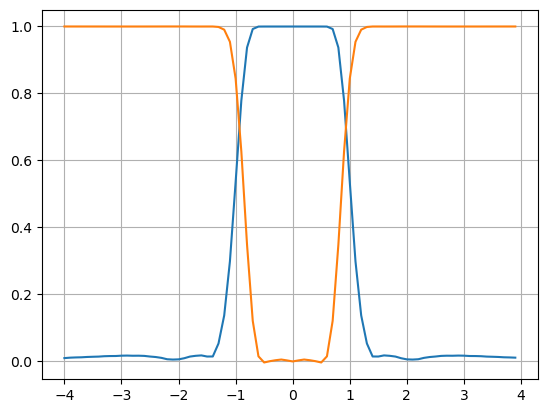

In [7]:
grad_amp_mt_m = 5.3/ (5/1.5)
grad_amp_t_cm = grad_amp_mt_m / (100 * 1E3)
grad_amp_hz_cm = grad_amp_t_cm * 42.577E6 
g = grad_amp_hz_cm* np.ones(exc_pulse_hz.shape)

dt = (pulse_dur_exc / 1E3) / exc_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = np.arange(-4,4,0.1, dtype=float)
df = 0 #np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(exc_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(dp,np.abs(mx+1j*my))
plt.plot(dp,mz)
plt.grid()
plt.show()


In [8]:
# Calculate asymmetry

np.argmin(np.abs(np.cumsum(pulse_raw)/pulse_raw.sum()-0.5)) / pulse_raw.size


0.8192307692307692

## Refocussing pulse

In [11]:
bw_1m = 50
R = bw_1m
pulse_dur_ref = 5.0
bw_tp = R/pulse_dur_ref
print(bw_tp)


10.0


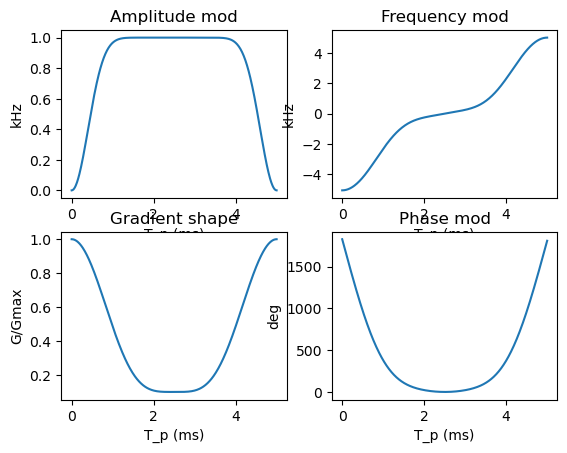

In [30]:
from goia_pulses import gen_goia_pulse

N = 16
M = 4 # Not 100% sure of this!
f=0.90
ref_dict = gen_goia_pulse(pulse_dur_ref, R, 'WURST', N, M, f, plot=True)

ref_pulse_cmplx = ref_dict['amp'] * np.exp(1j* (np.pi/180) * ref_dict['phz'])

In [14]:
# Gradient calc
thickness = 2 
hz_cm = R / (thickness * pulse_dur_ref*1E-3)
print(hz_cm)

grad_amp_mt_m = 15.1
grad_amp_t_cm = grad_amp_mt_m / (100 * 1E3)
grad_amp_hz_cm = grad_amp_t_cm * 42.577E6 
print(grad_amp_hz_cm)

5000.0
6429.1269999999995


Pulse power: 723.809 Hz


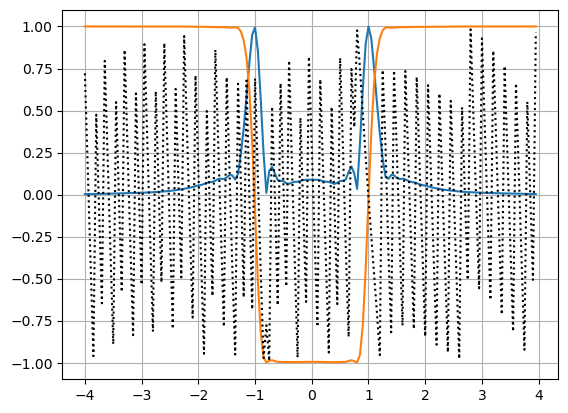

In [15]:
pulse_max_hz = 17 * 42.577
ref_pulse_hz = ref_pulse_cmplx * pulse_max_hz
print(f'Pulse power: {pulse_max_hz} Hz')

ref_pulse_grad = ref_dict['grad']
g = ref_pulse_grad * hz_cm #grad_amp_hz_cm 

dt = (pulse_dur_ref*1E-3) / ref_pulse_hz.size
t1 = 5.0
t2 = 5.0
dp = np.arange(-4,4,0.05, dtype=float)
df = np.array([0, 300, 600, 900])
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(ref_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

plt.plot(dp,np.abs(mx[0]+1j*my[0]))
plt.plot(dp,mz[0])
plt.plot(dp,np.angle(mx[0]+1j*my[0])/np.pi,'k:')
plt.grid()
plt.show()

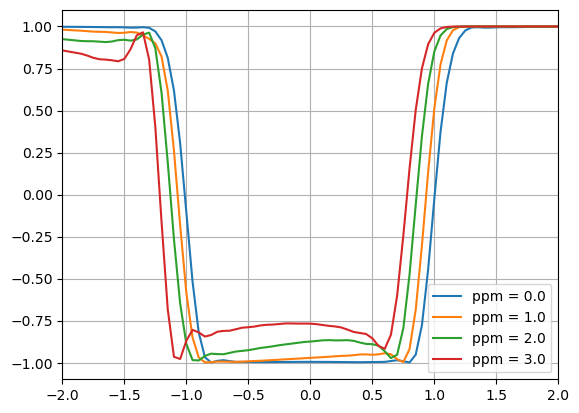

In [16]:
plt.plot(dp,mz.T,label=[f'ppm = {x/300}' for x in df])
plt.xlim([-2, 2])
plt.grid()
plt.legend()
plt.show()

In [26]:
# Adiabatic limit
B1_hz_vec = np.arange(100,1500,25)
dp = np.arange(-4,4,0.1, dtype=float)
df = np.array([0, 300, 600, 900])
dur_vec = [3,4,5]
mxy_store_dur = []
mz_store_dur = []
for dur in dur_vec :
    dt2 = (dur / 1E3) / ref_pulse_hz.size
    mxy_store = []
    mz_store = []
    for b1 in B1_hz_vec:
        ref_pulse_hz = ref_pulse_cmplx * b1
        mx, my, mz = bloch(ref_pulse_hz, g, dt2, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)
        mxy_store.append(np.abs(mx+1j*my))
        mz_store.append(mz)

    mxy_store_dur.append(np.stack(mxy_store,axis=1))
    mz_store_dur.append(np.stack(mz_store,axis=1))

mxy_store_dur = np.asarray(mxy_store_dur)
mz_store_dur = np.asarray(mz_store_dur)

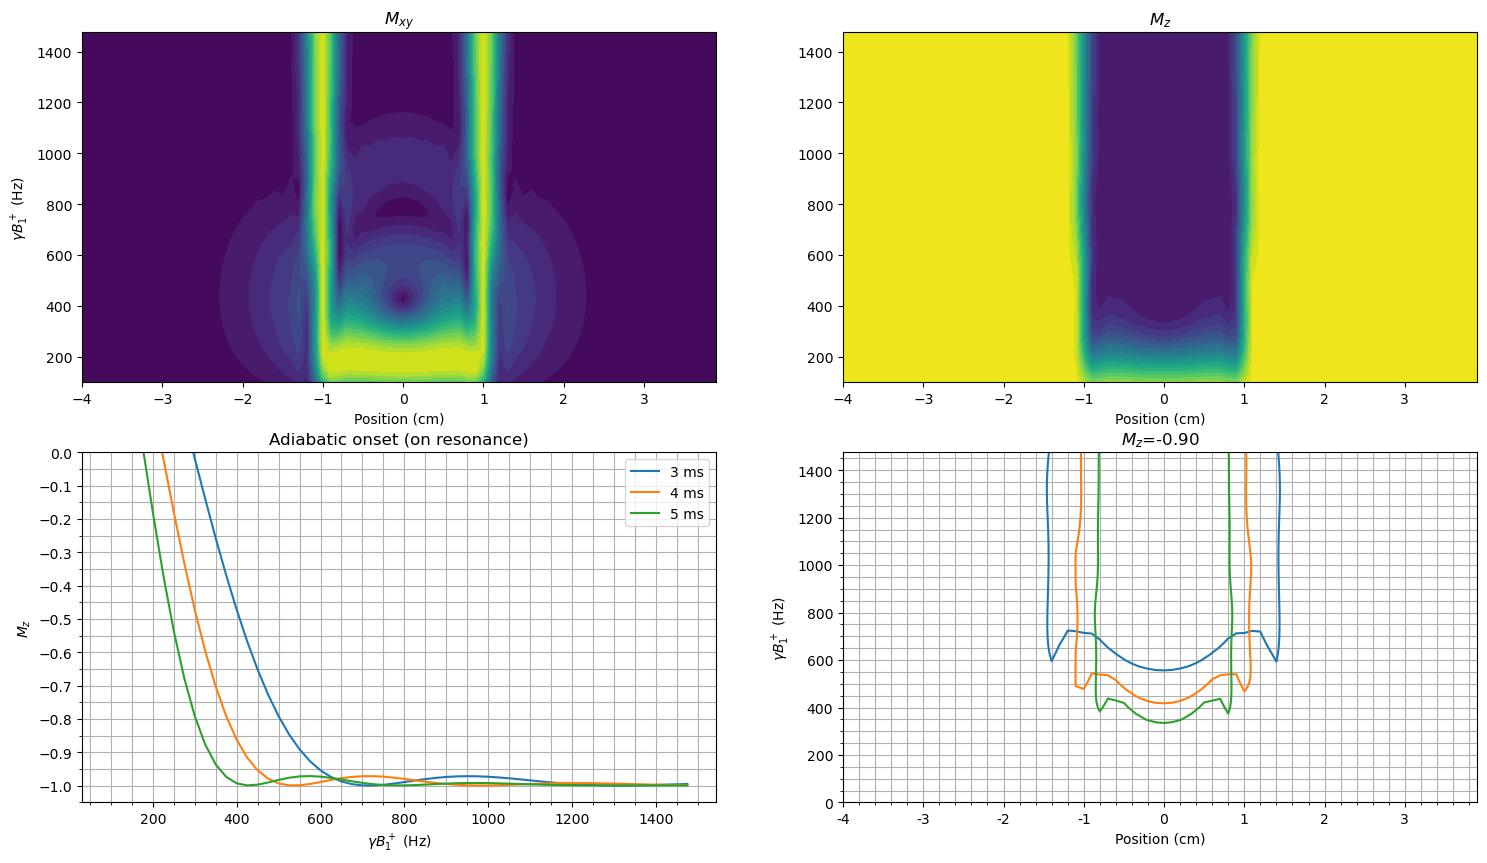

In [27]:
fig, ax = plt.subplots(2,2,figsize=(18,10),sharey=False)
ax[0][0].contourf(dp,B1_hz_vec,mxy_store_dur[2,0,:,:], levels= np.arange(0,1.1,0.05))
ax[0][1].contourf(dp,B1_hz_vec,mz_store_dur[2,0,:,:], levels= np.arange(-1.1,1.1,0.10))

lineObjects = ax[1][0].plot(B1_hz_vec, mz_store_dur[:,0,:,int(dp.size/2)].squeeze().T)
ax[1][0].legend(lineObjects, [f'{x} ms' for x in dur_vec])

for mz, lo in zip(mz_store_dur, lineObjects):
    ax[1][1].contour(dp,B1_hz_vec,mz[0,:,:], levels=(-0.90,), colors=lo.get_color(), linestyles='solid')


ax[0][0].set_ylabel('$\gamma B_1^+$ (Hz)')
ax[0][0].set_xlabel('Position (cm)')
ax[0][1].set_xlabel('Position (cm)')
ax[0][0].set_title('$M_{xy}$')
ax[0][1].set_title('$M_{z}$')

# ax[1][0].set_xlim([0, 2000])
ax[1][0].set_ylim([-1.05, 0])
ax[1][0].set_xlabel('$\gamma B_1^+$ (Hz)')
ax[1][0].set_ylabel('$M_{z}$')

ax[1][0].xaxis.set_major_locator(MultipleLocator(200))
ax[1][0].xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax[1][0].xaxis.set_minor_locator(MultipleLocator(50))
ax[1][0].yaxis.set_major_locator(MultipleLocator(0.1))
# ax[1][0].yaxis.set_major_formatter('{x:.0f}')
ax[1][0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1][0].grid(which='both')

ax[1][1].set_ylim([0, B1_hz_vec.max()])
ax[1][1].xaxis.set_major_locator(MultipleLocator(1))
ax[1][1].xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax[1][1].xaxis.set_minor_locator(MultipleLocator(0.2))
ax[1][1].yaxis.set_major_locator(MultipleLocator(200))
# ax[1][0].yaxis.set_major_formatter('{x:.0f}')
ax[1][1].yaxis.set_minor_locator(MultipleLocator(50))
ax[1][1].grid(which='both')
ax[1][1].set_ylabel('$\gamma B_1^+$ (Hz)')
ax[1][1].set_xlabel('Position (cm)')
ax[1][0].set_title('Adiabatic onset (on resonance)')
ax[1][1].set_title('$M_{z}$=-0.90')
plt.show()